In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from data import load_dataset, get_train_test_split
from optimization import gp_optimize_threshold
from evaluation import train_and_test_other_models

In [2]:
filename = "dataset/LoanStats3a.csv"
features, data = load_dataset(filename)
print("Data shape: %s" % str(features.shape))

Preprocessing...
Feature Engineering...
Data shape: (42535, 40)


In [3]:
X_train, X_test, y_train, y_test = get_train_test_split(features, test_size=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# Temporarily use subset of data to debug faster
# TODO: Remove
X_train, y_train = X_train[:1000,:], y_train[:1000]
X_val, y_val     = X_val[:500,:], y_val[:500]
X_test, y_test   = X_test[:500,:], y_test[:500]

# Normalize
X_scaler = MinMaxScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)

print("X_train: %s, y_train: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_val: %s, y_val: %s" % (str(X_val.shape), str(y_val.shape)))
print("X_test: %s, y_test: %s" % (str(X_test.shape), str(y_test.shape)))

X_train: (1000, 38), y_train: (1000,)
X_val: (500, 38), y_val: (500,)
X_test: (500, 38), y_test: (500,)


In [4]:
# Gaussian Process
import GPy

# Normalize
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape(-1,1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1,1))

# Initialize GP Model
kernel = GPy.kern.RBF(input_dim=X_train.shape[1], variance=1., lengthscale=1.)
gp_model = GPy.models.GPRegression(X_train, y_train_scaled, kernel)
gp_model.optimize()


In [5]:
from simulation import *

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

SEED            = 1
THRESHOLD       = 1.1
NUM_PERIODS     = 20
NUM_MONTHS      = 120
FUND_GIVEN      = 1e6
LOANS_PER_MONTH = 100
CONF_QUANTILE   = (40,100)

perf_gp = simulate_N_time_periods(gp_model, X_val, y_val, X_scaler, y_scaler, 
                                  threshold=THRESHOLD, num_periods=NUM_PERIODS, fund_given=FUND_GIVEN, 
                                  num_months=NUM_MONTHS,incoming_loans_per_time_period=LOANS_PER_MONTH,
                                  conf_quantile=CONF_QUANTILE, optimize_for="TODO", 
                                  version="threshold_and_variance", model_type="gp", seed=SEED)

from sklearn.svm import SVR
svm_rbf = SVR(kernel="rbf", C=1e4)
svm_rbf.fit(X_train, y_train)
perf_others = simulate_N_time_periods(svm_rbf, X_val, y_val, X_scaler, y_scaler, 
                                      threshold=THRESHOLD*1.05, num_periods=NUM_PERIODS, fund_given=FUND_GIVEN, 
                                      num_months=NUM_MONTHS, incoming_loans_per_time_period=LOANS_PER_MONTH,
                                      conf_quantile=None, optimize_for="TODO", 
                                      version="threshold_only", model_type="others", seed=SEED)

print("Mean Total Profits:")
print(np.mean(np.sum(perf_gp[:,:,0], axis=1)))
print(np.mean(np.sum(perf_others[:,:,0], axis=1)))

Simulating period 0...
Simulating period 10...
Simulating period 0...
Simulating period 10...
Mean Total Profits:
3183285.65485
616157.995504


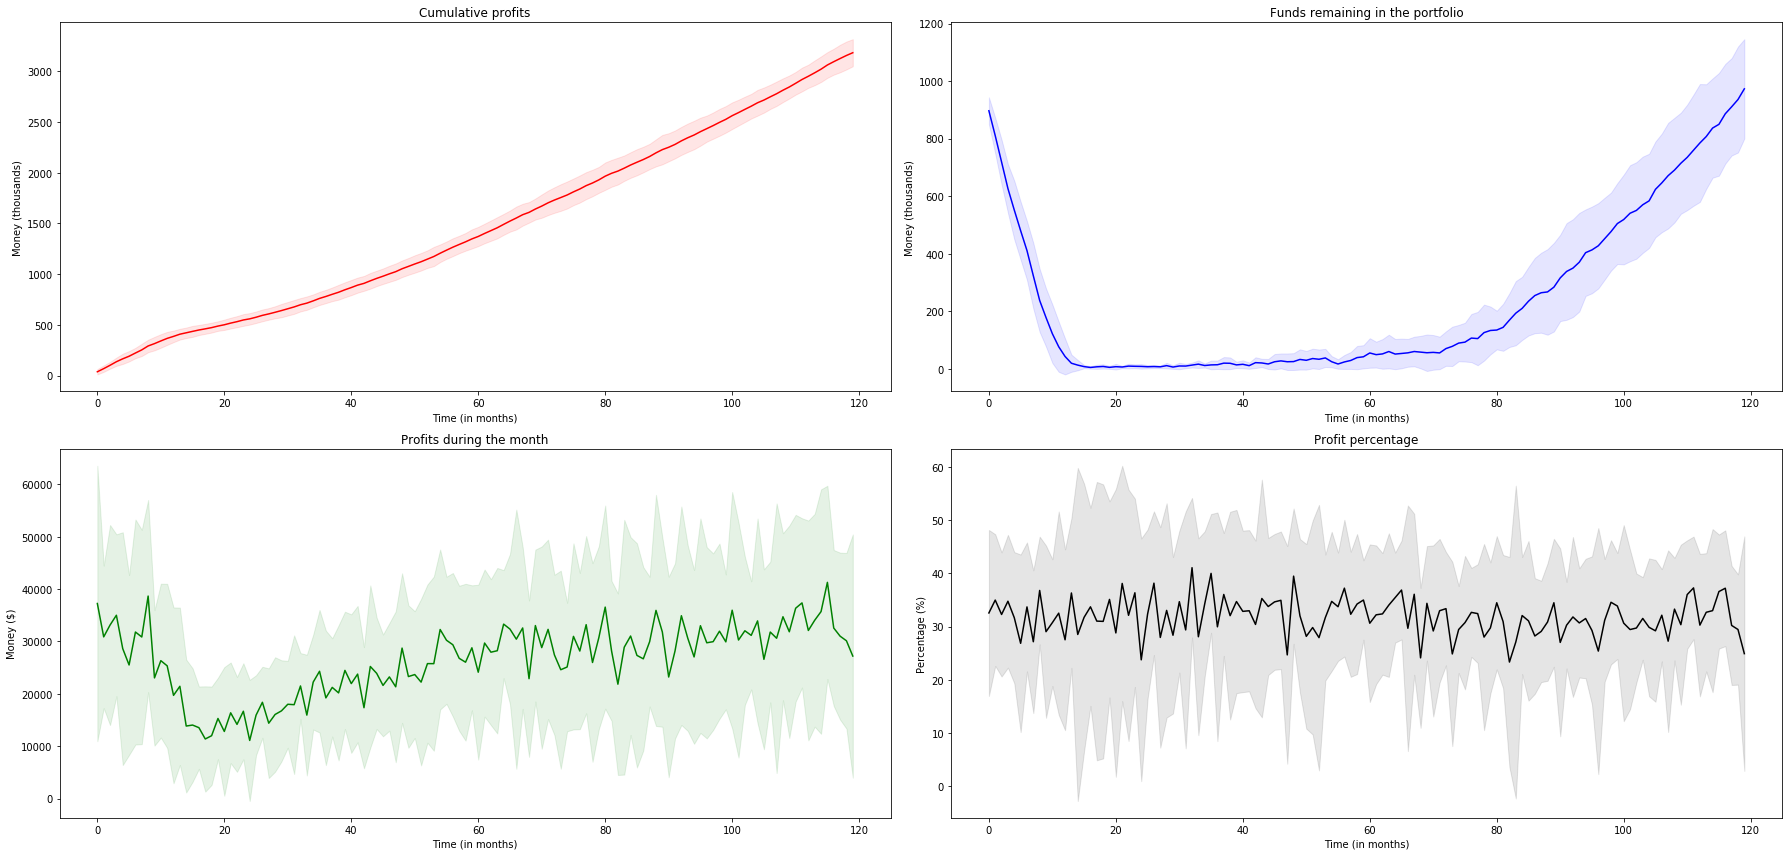

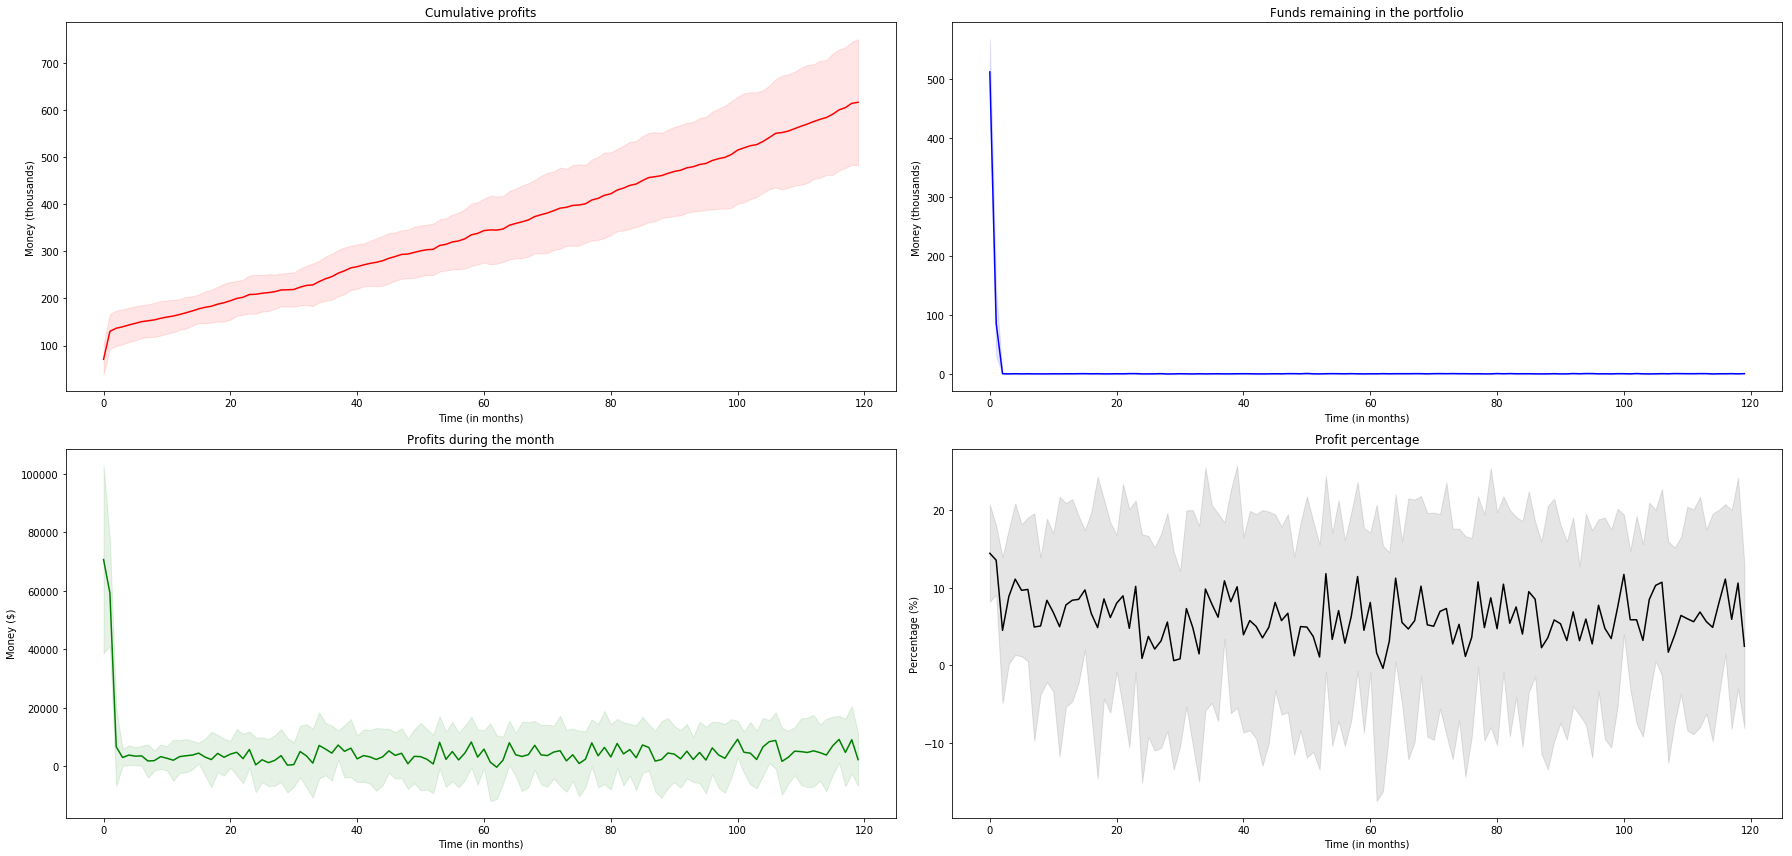

In [6]:
from visualisation import plot_portfolio_performance
plot_portfolio_performance(perf_gp)
plot_portfolio_performance(perf_others)

In [250]:
# Optimize threshold for profits / profit_percentage
threshold = gp_optimize_threshold(gp_model, X_val, y_val, X_scaler, y_scaler, optimize_for="profit_percentage")
"""
print("\n---- Optimizing threshold using X_val ----")
print("Threshold: %f" % threshold)
lend_using_target_only(regressed_payment, X_val, y_val, X_scaler, threshold=1.0)
lend_using_target_only(regressed_payment, X_val, y_val, X_scaler, threshold=threshold)

# Test threshold value on test set
y_hat, conf = gp_model.predict(X_test)
regressed_payment = y_scaler.inverse_transform(y_hat).reshape(-1)
print("\n----------- Testing on X_test ------------")
lend_using_target_only(regressed_payment, X_test, y_test, X_scaler, threshold=1.0)
lend_using_target_only(regressed_payment, X_test, y_test, X_scaler, threshold=threshold)
"""
print(threshold)

1.15862234903


In [ ]:
train_and_test_other_models(X_train, y_train, X_test, y_test, X_scaler)